In [371]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from Data_Utils import *
from Plot_Utils import *
from Math_Utils import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchdiffeq import odeint

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        memory = self.encoder(self.src_embed(src), src_mask)
        output = self.decoder(self.tgt_embed(tgt), memory, 
                              src_mask, tgt_mask)
        return output

In [355]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [48]:
device

device(type='cpu')

In [49]:
data_path='..SNCRL_Dataset/CellCycle/'
DS=Dataset(data_path,1)

successly load time
(1400000, 44) (600000, 44) (100000, 44)
self.train_dl (1400000, 44)


In [75]:
def remap(x, out_min, out_max):
    in_min, in_max = np.min(x), np.max(x)
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

In [356]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [357]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [358]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Residual connection"
        return x + self.dropout(sublayer(self.norm(x)))

In [359]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [360]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [361]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

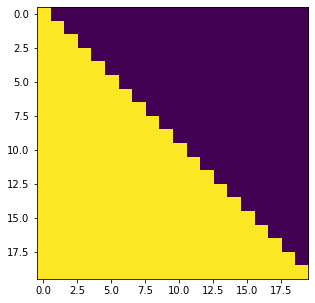

In [363]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0



In [364]:
def attention(query, key, value, mask=None, dropout=0.0):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    # (Dropout described below)
    p_attn = F.dropout(p_attn, p=dropout)
    return torch.matmul(p_attn, value), p_attn

In [102]:
class LcODEfunc(nn.Module):
    def __init__(self, latent_dim=4, nhidden=20):
        super(LcODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)   # outputs latent state of dim 4
        self.nfe = 0
    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out

In [365]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.p = dropout
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.p)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [366]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # Torch linears have a `b` by default. 
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [367]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

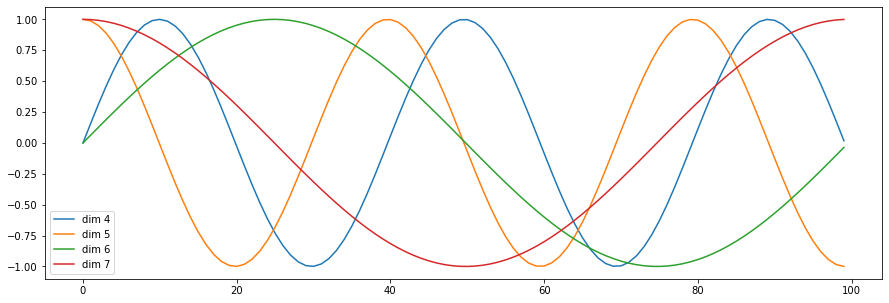

In [372]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

# The frequency and offset of the wave is different for each dimension.
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

In [373]:
class Generator(nn.Module):
    "Standard generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [377]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [341]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)
    def forward(self,z,len_period):
        #res0=[]
        #res=torch.zeros([z.size(0),z.size(1),z.size(2)*2])
        #n_period=z.size(1)//len_period
        #print(n_period)
        #clip=z.size(1)-len_period*n_period
        #print(clip)
        #print('z.shape is',z.shape)
        #print('DEC z.shape is',z.shape)
        #for i in range(n_period):
        #out = self.fc1(z[:,i*len_period:(i+1)*len_period,:])
           # print('out_n.shape is what',out.shape)
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
       # res0.append(out)
        #out=torch.stack(res0,axis=1)
        #print('out.shape is what',out.shape)
        #out_m=torch.mean(out,axis=1)
        #print('out.m is what',out_m.shape)
        #for i in range(n_period):
        #    res[:,i*len_period:(i+1)*len_period,:]=out_m
        #res[:,z.size(1)-clip:,:]=out_m[:,:clip,:]
        #print('res.shape is what',res[:,z.size(1)-clip:z.size(1),:])
        return out

In [378]:
tmp_model = make_model(10, 10, 2)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [379]:
# Note: This part is very important. 
# Need to train with this setup of the model is very unstable.
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup**(-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
    torch.optim.Adam(model.parameters(),
        lr=0, betas=(0.9, 0.98), eps=1e-9))

In [342]:
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)

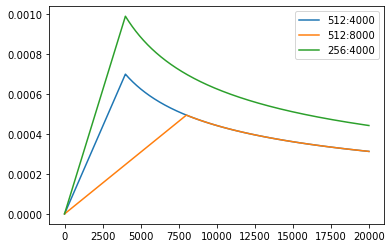

In [380]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

Iter: 10, running avg elbo: -147925536.3287


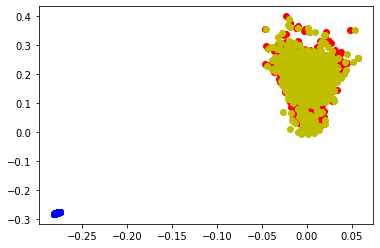

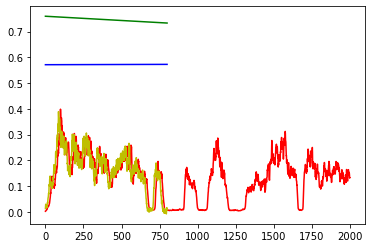

Iter: 20, running avg elbo: -147589746.4447


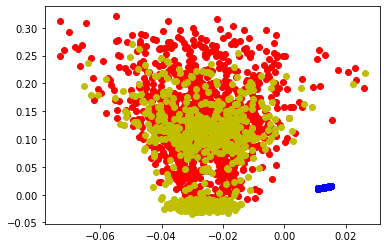

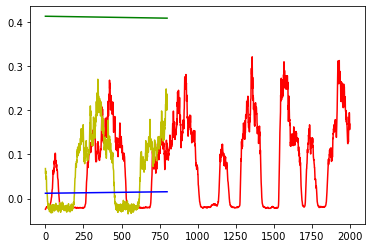

Iter: 30, running avg elbo: -147277647.3535


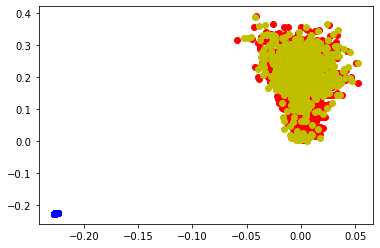

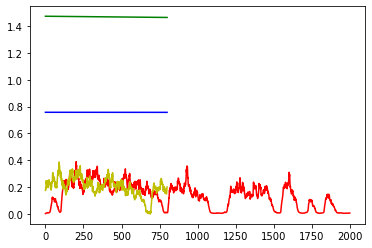

Iter: 40, running avg elbo: -147091137.8419


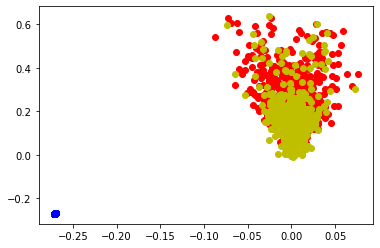

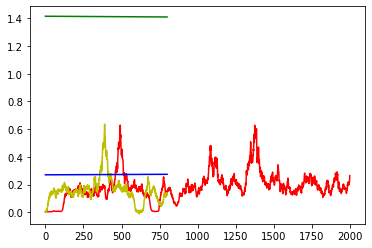

Iter: 50, running avg elbo: -146998745.7187


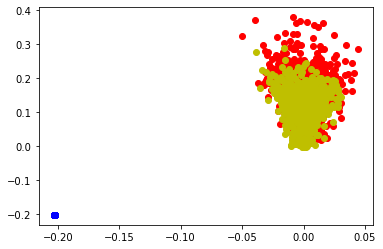

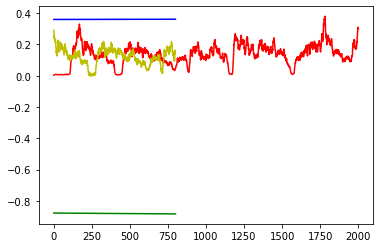

Iter: 60, running avg elbo: -146773595.7738


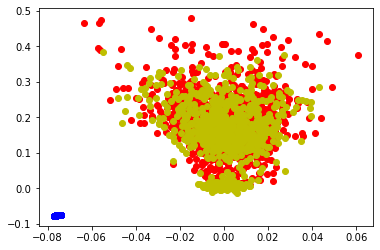

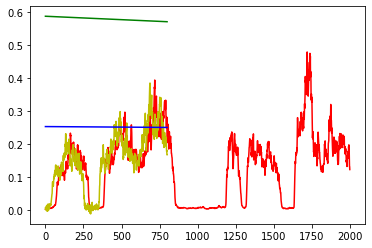

Iter: 70, running avg elbo: -146614517.5373


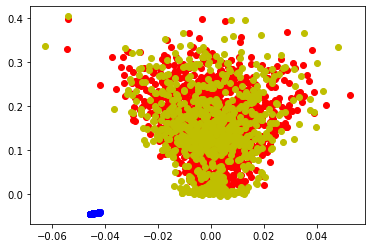

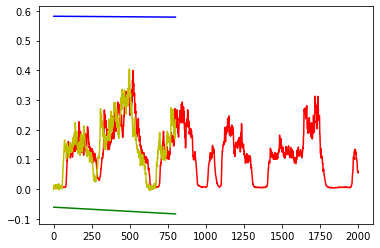

Iter: 80, running avg elbo: -146352337.6564


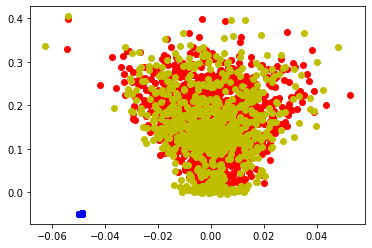

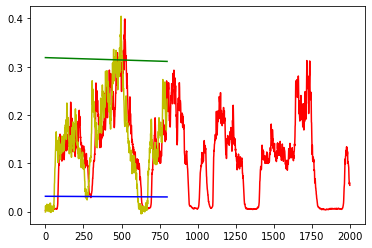

Iter: 90, running avg elbo: -146213078.4070


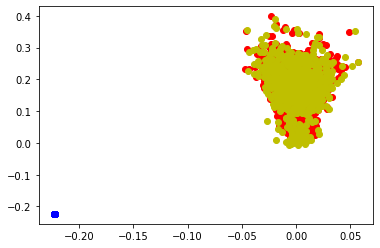

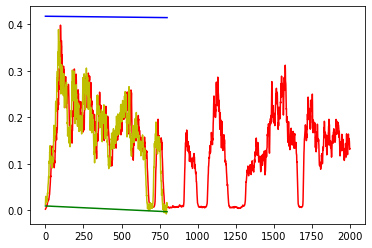

Iter: 100, running avg elbo: -145980957.5881


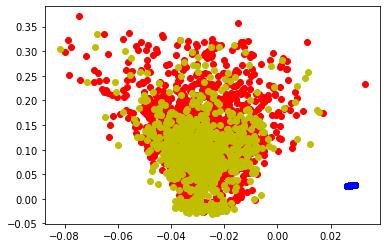

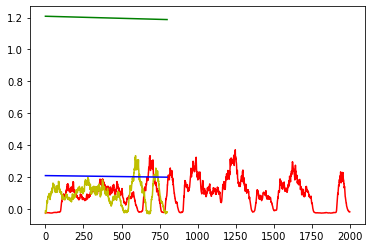

Iter: 110, running avg elbo: -145867842.9743


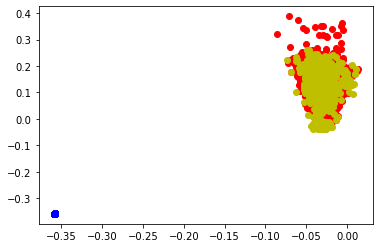

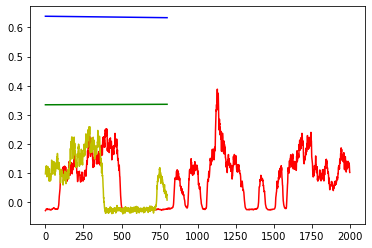

Iter: 120, running avg elbo: -145817600.3353


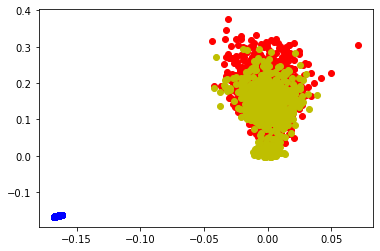

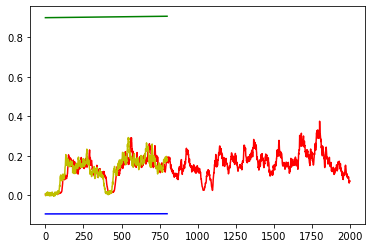

Iter: 130, running avg elbo: -145688323.9339


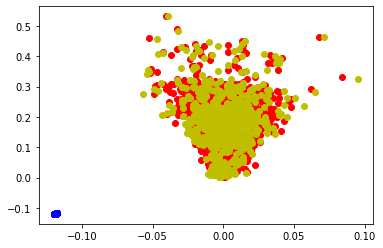

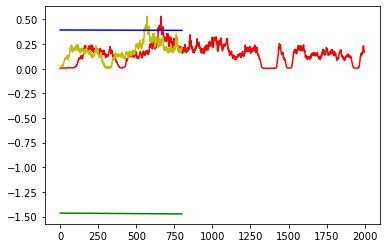

Iter: 140, running avg elbo: -145631053.9241


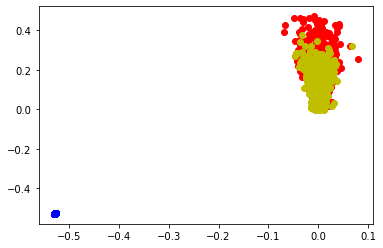

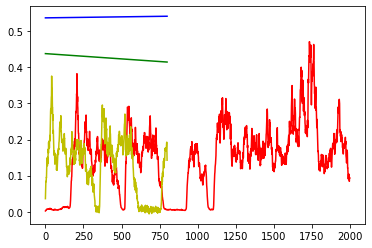

Iter: 150, running avg elbo: -145441318.1916


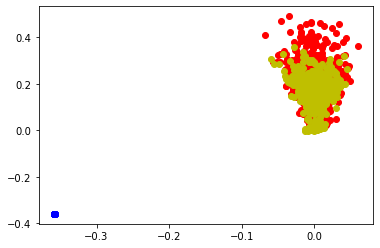

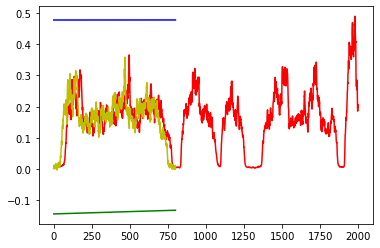

Iter: 160, running avg elbo: -145370584.0811


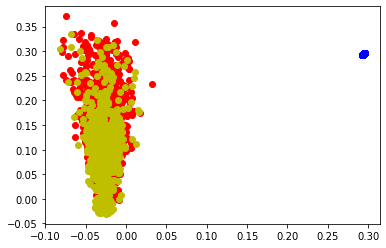

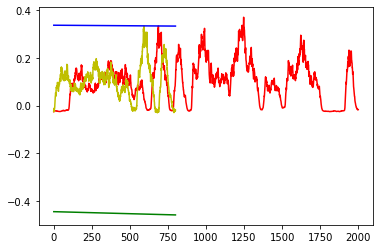

Iter: 170, running avg elbo: -145140426.7890


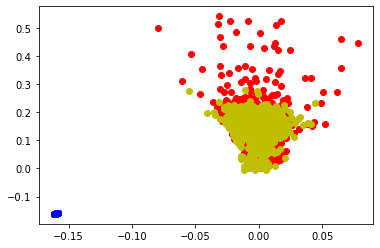

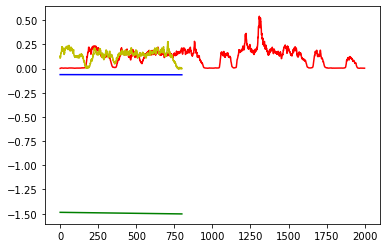

Iter: 180, running avg elbo: -144971418.2431


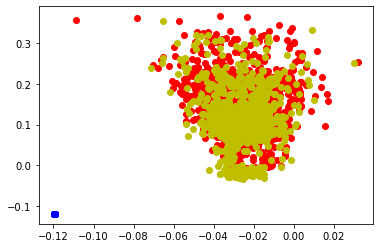

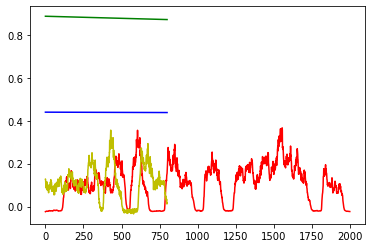

Iter: 190, running avg elbo: -144786106.8993


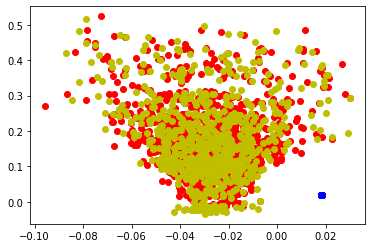

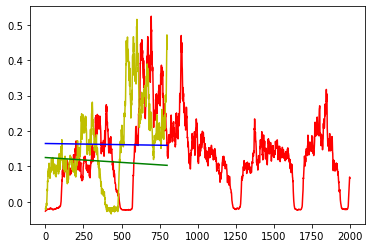

Iter: 200, running avg elbo: -144661849.2001


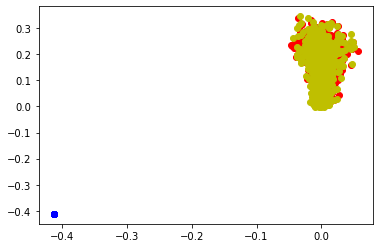

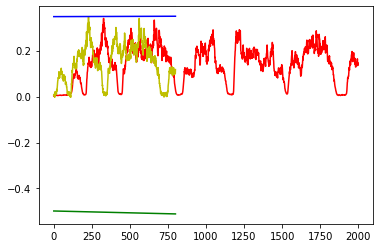

Iter: 210, running avg elbo: -144557693.3282


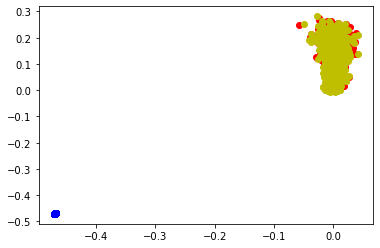

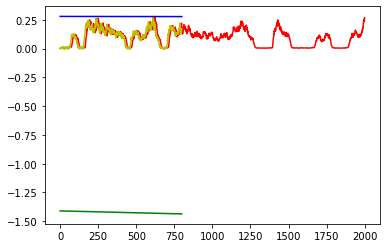

Iter: 220, running avg elbo: -144697580.6955


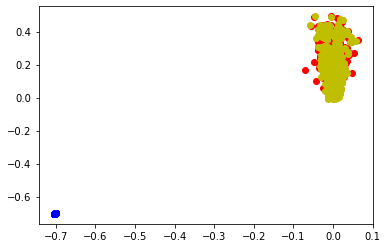

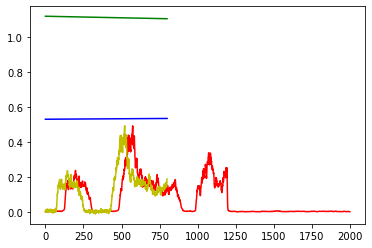

Iter: 230, running avg elbo: -144638330.7633


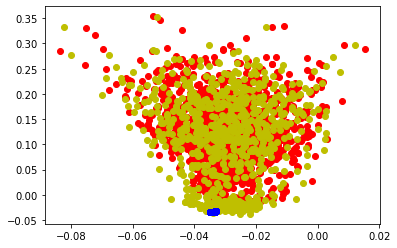

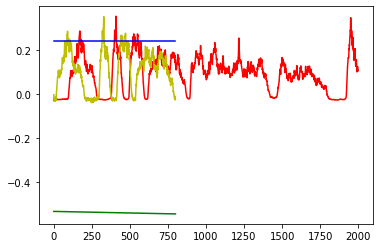

Iter: 240, running avg elbo: -144397991.6126


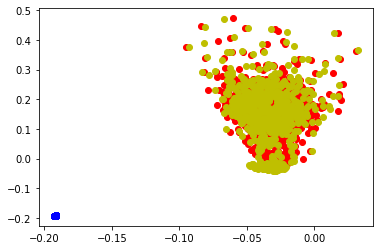

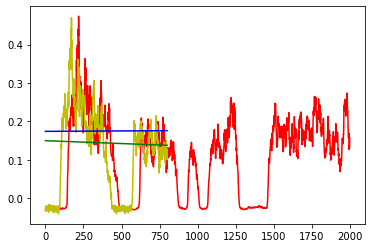

Iter: 250, running avg elbo: -144429094.6954


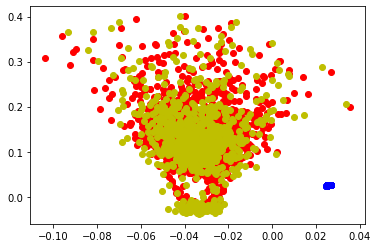

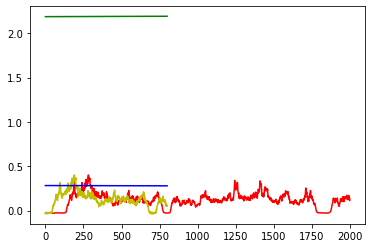

Iter: 260, running avg elbo: -144450115.5371


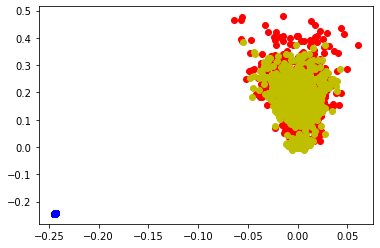

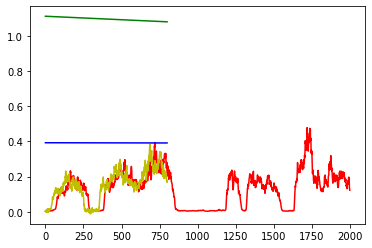

Iter: 270, running avg elbo: -144527387.3489


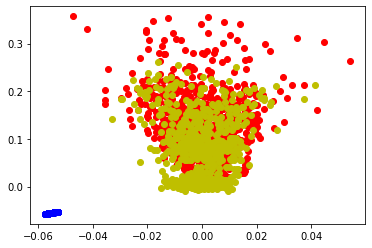

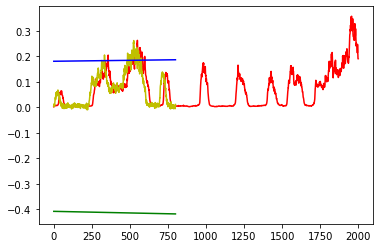

Iter: 280, running avg elbo: -144540460.8128


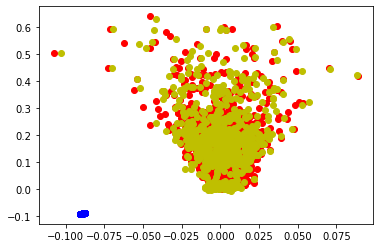

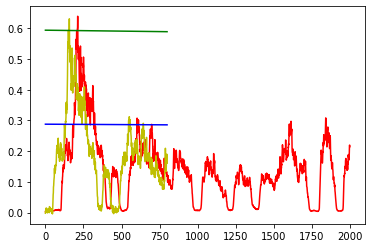

Iter: 290, running avg elbo: -144654425.1725


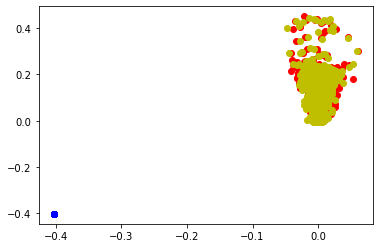

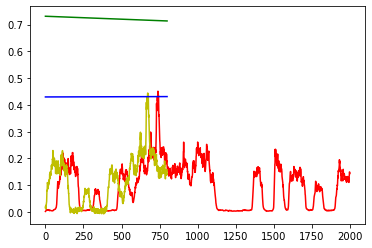

Iter: 300, running avg elbo: -144725836.8590


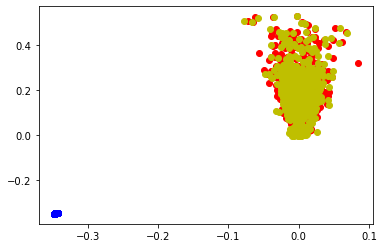

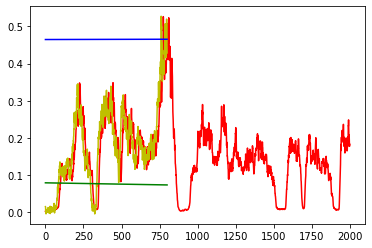

Iter: 310, running avg elbo: -144666918.3296


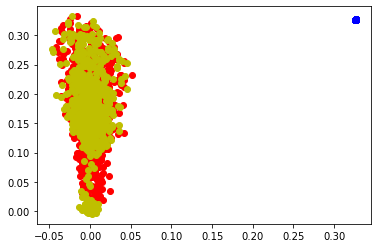

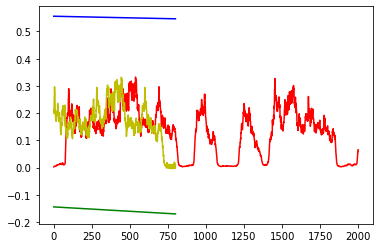

Iter: 320, running avg elbo: -144673314.6840


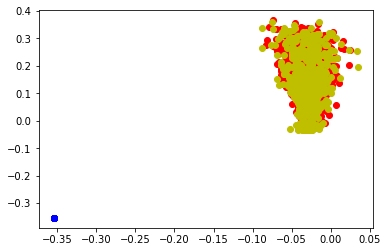

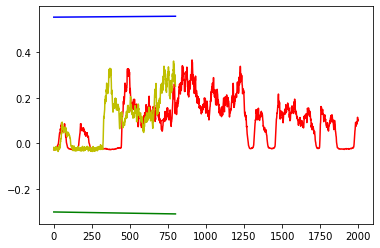

Iter: 330, running avg elbo: -144645723.9971


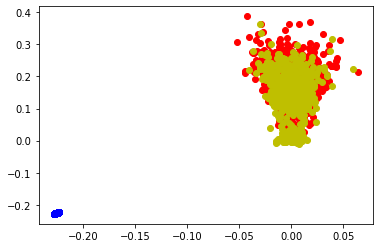

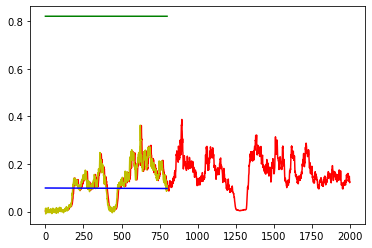

Iter: 340, running avg elbo: -144657835.5364


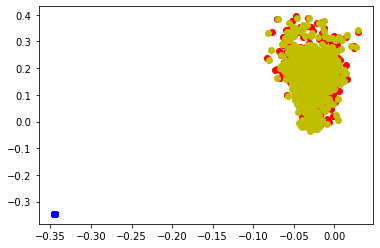

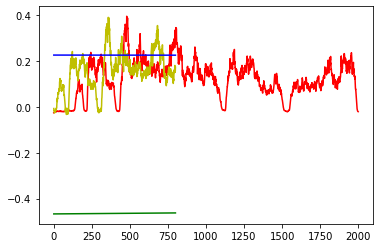

Iter: 350, running avg elbo: -144772542.3544


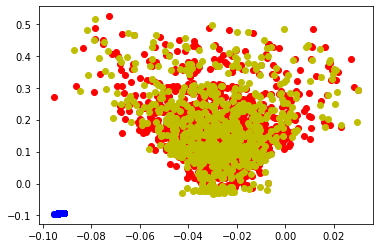

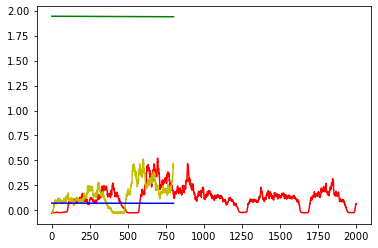

Iter: 360, running avg elbo: -144873656.6380


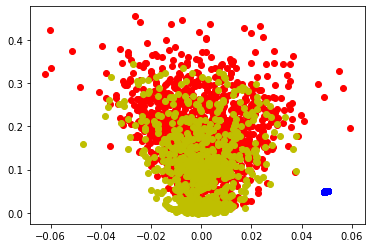

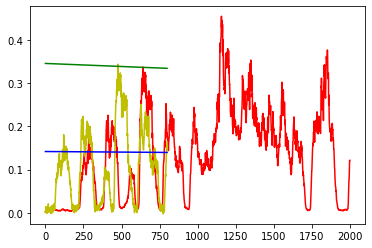

Iter: 370, running avg elbo: -144787239.6024


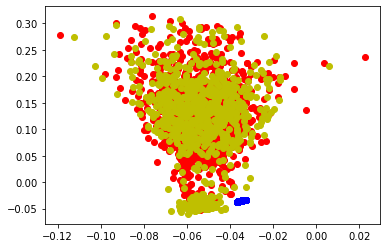

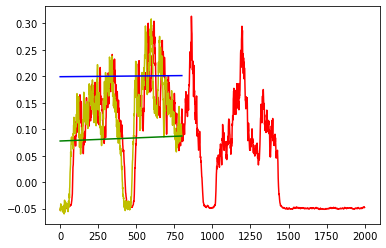

Iter: 380, running avg elbo: -144776341.2941


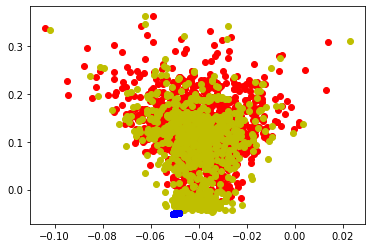

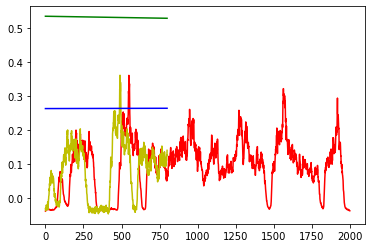

Iter: 390, running avg elbo: -144682595.1985


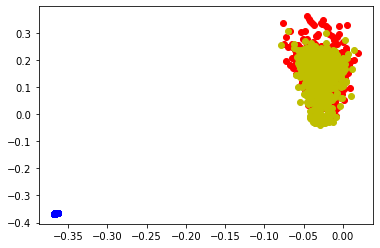

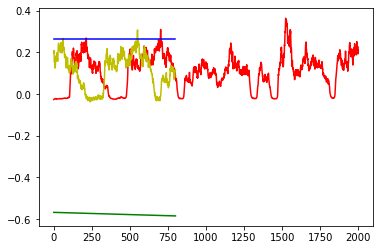

Iter: 400, running avg elbo: -144520843.4566


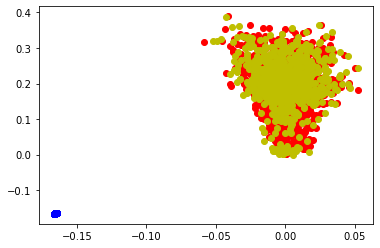

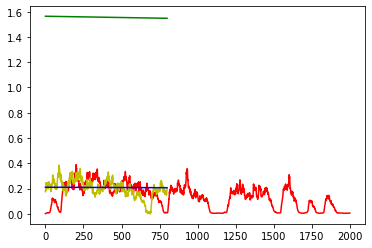

Iter: 410, running avg elbo: -144452098.1070


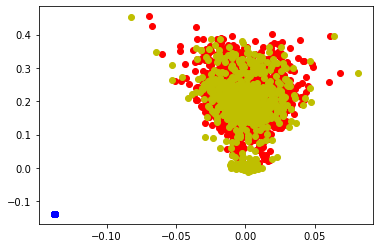

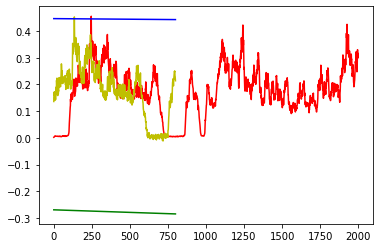

Iter: 420, running avg elbo: -144331030.4251


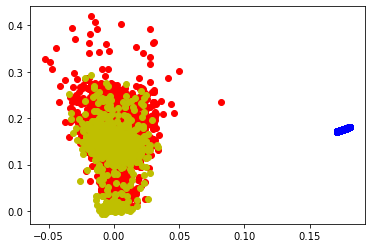

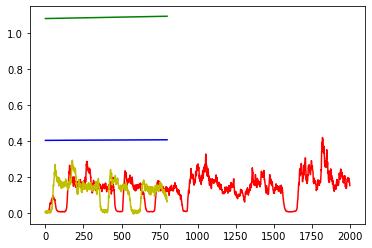

Iter: 430, running avg elbo: -144274132.0209


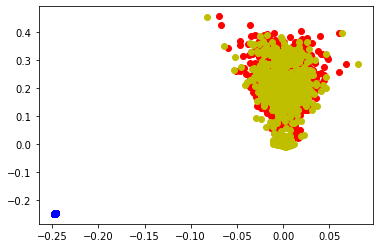

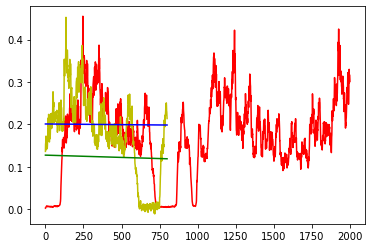

Iter: 440, running avg elbo: -144373769.0203


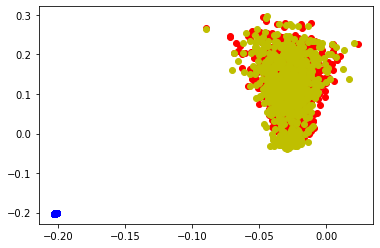

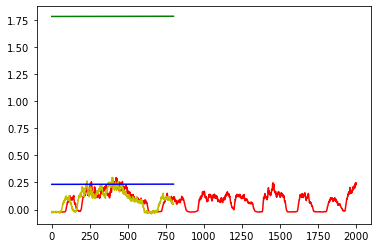

Iter: 450, running avg elbo: -144245401.2857


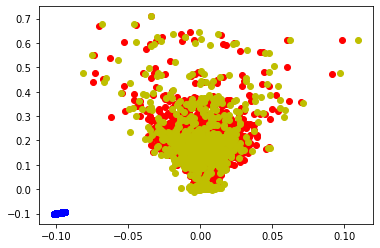

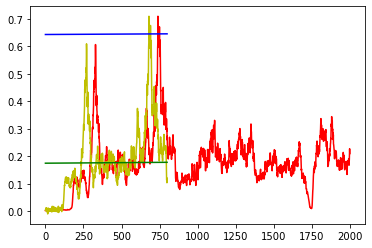

Iter: 460, running avg elbo: -144192075.4425


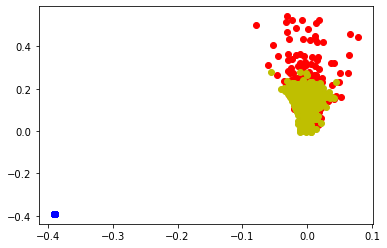

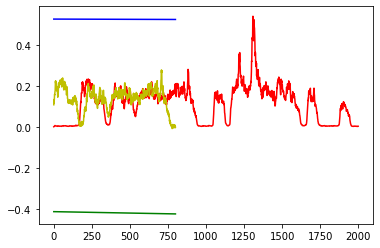

Iter: 470, running avg elbo: -144208929.5620


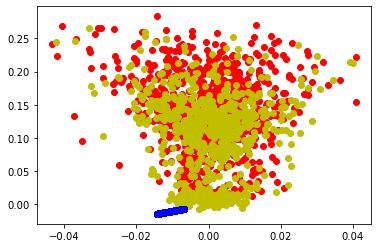

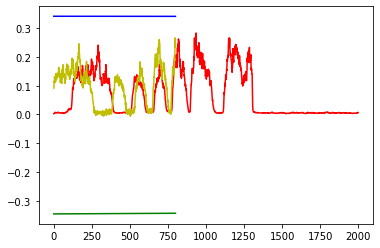

Iter: 480, running avg elbo: -144327179.6609


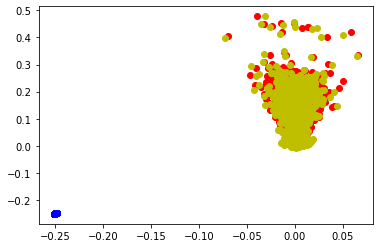

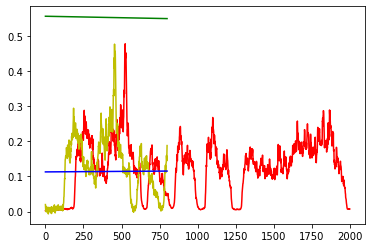

Iter: 490, running avg elbo: -144075889.0773


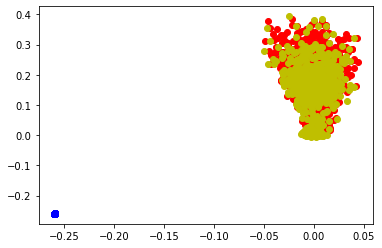

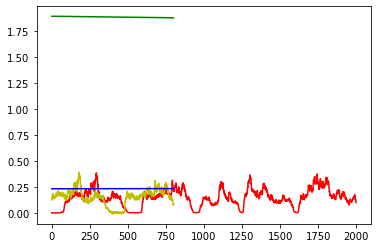

Iter: 500, running avg elbo: -144055816.6938


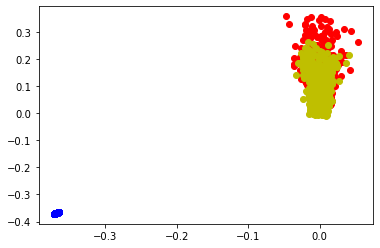

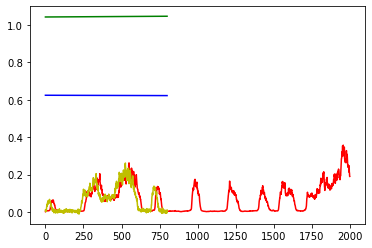

Iter: 510, running avg elbo: -144067181.5510


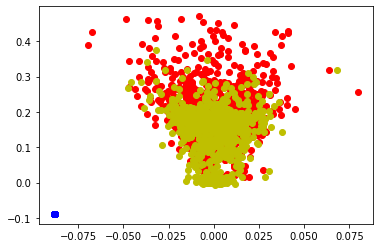

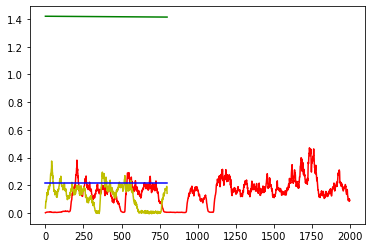

Iter: 520, running avg elbo: -144141835.5241


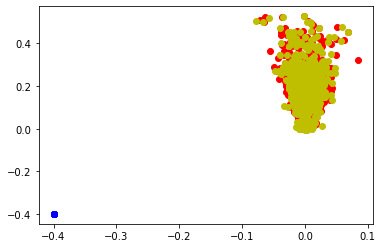

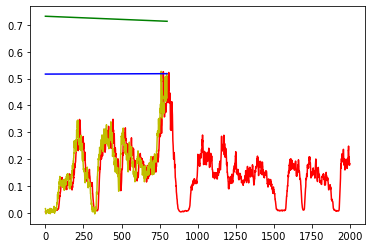

Iter: 530, running avg elbo: -144165407.1251


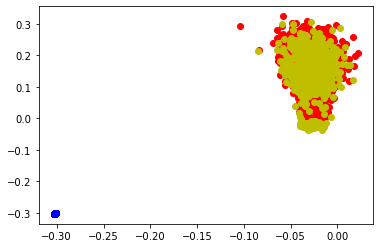

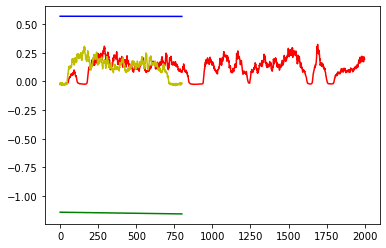

Iter: 540, running avg elbo: -144155892.0488


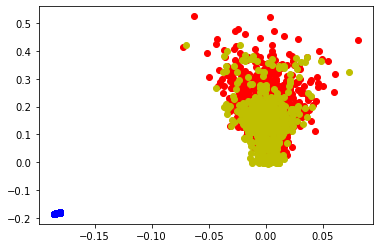

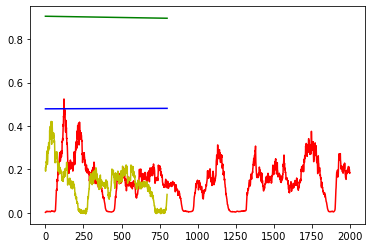

Iter: 550, running avg elbo: -144170781.7218


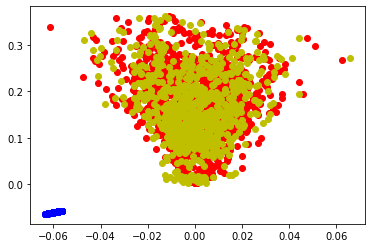

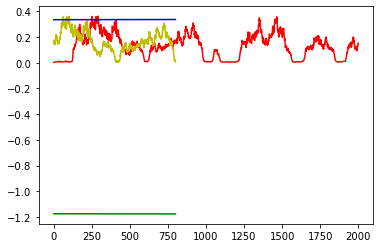

Iter: 560, running avg elbo: -144111685.5815


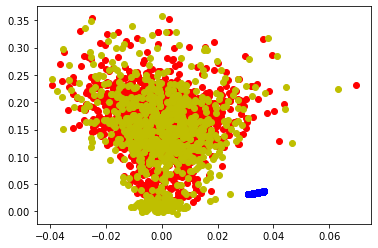

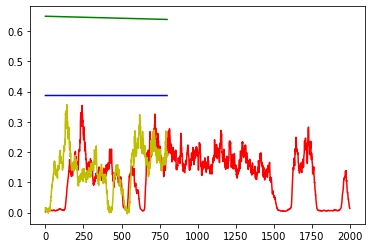

Iter: 570, running avg elbo: -144111266.1761


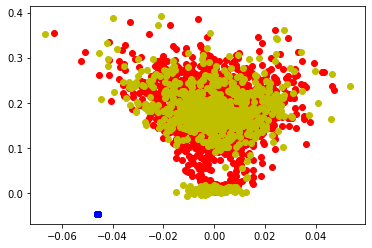

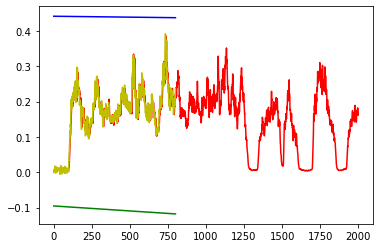

Iter: 580, running avg elbo: -143932364.2760


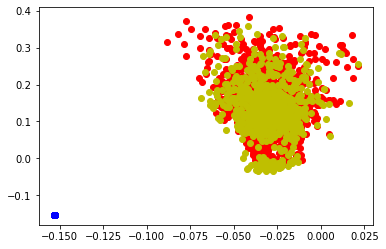

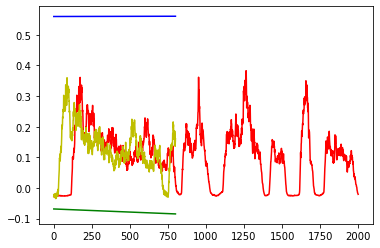

Iter: 590, running avg elbo: -143975676.7096


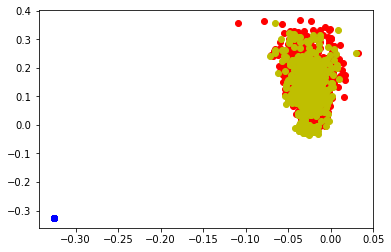

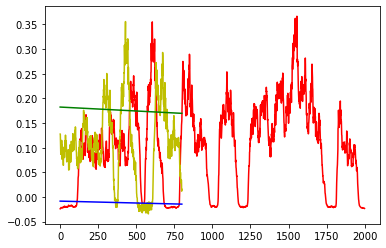

Iter: 600, running avg elbo: -144075675.6679


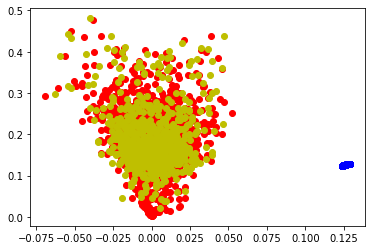

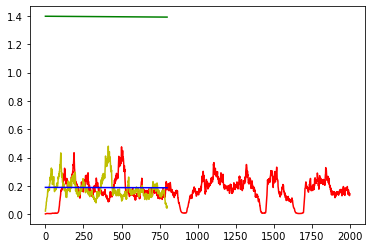

Iter: 610, running avg elbo: -144050159.9613


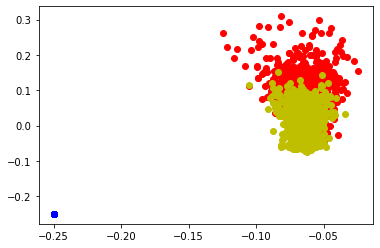

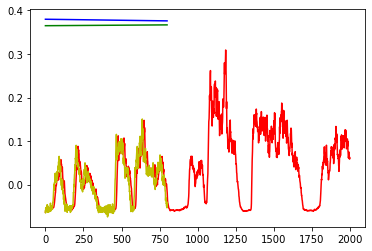

Iter: 620, running avg elbo: -144111044.2904


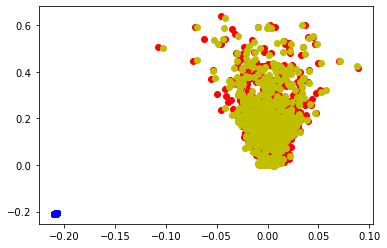

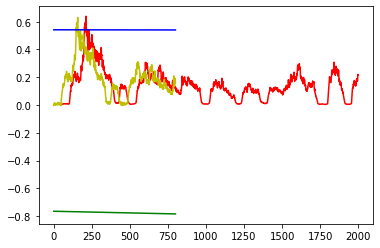

Iter: 630, running avg elbo: -144142967.5814


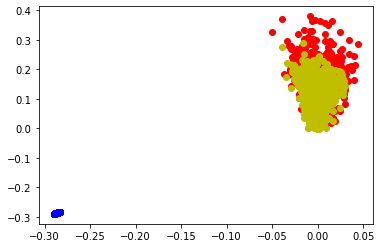

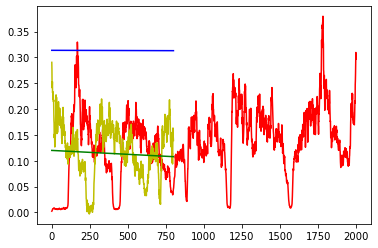

Iter: 640, running avg elbo: -144133818.8545


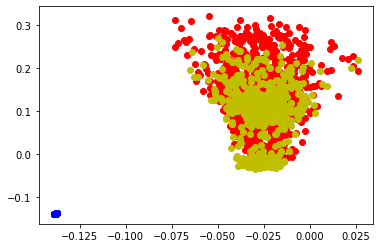

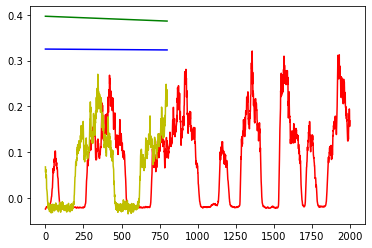

Iter: 650, running avg elbo: -144113874.3405


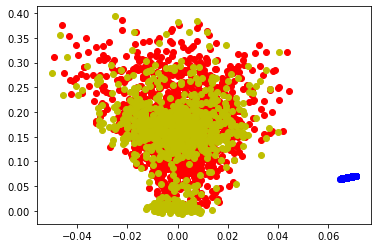

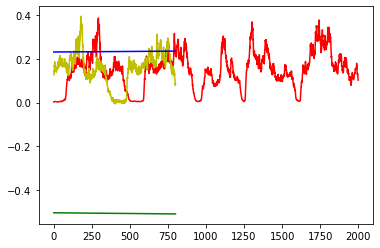

Iter: 660, running avg elbo: -144117760.4555


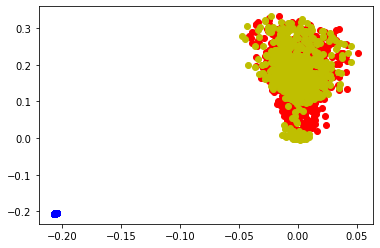

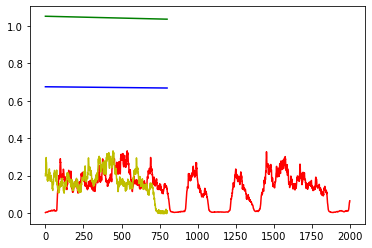

Iter: 670, running avg elbo: -144034955.0296


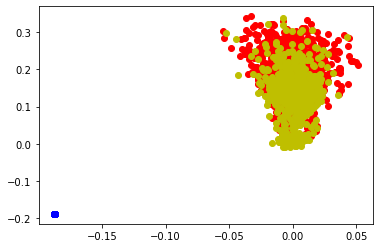

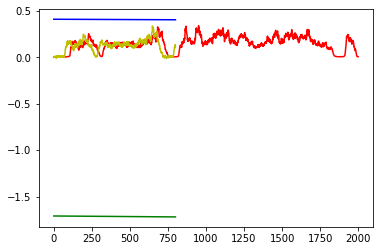

Iter: 680, running avg elbo: -144088055.3243


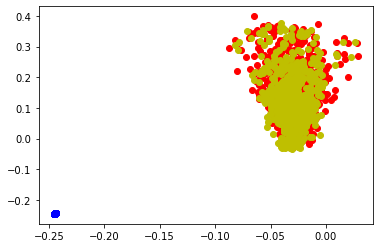

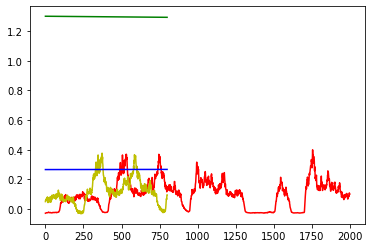

Iter: 690, running avg elbo: -144335131.8219


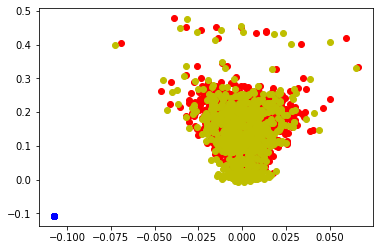

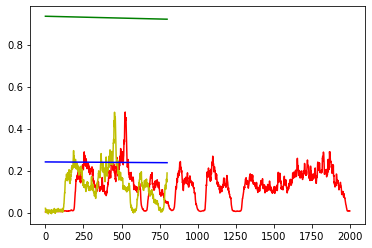

Iter: 700, running avg elbo: -144470458.7744


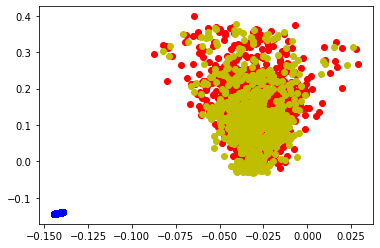

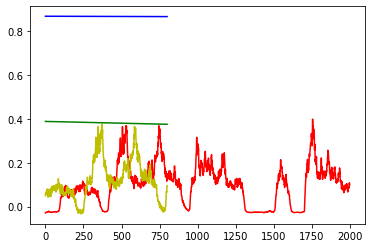

Iter: 710, running avg elbo: -144357018.8303


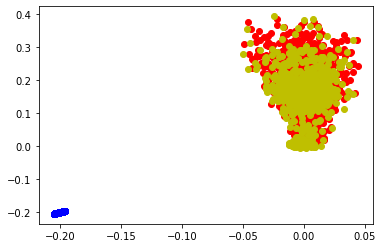

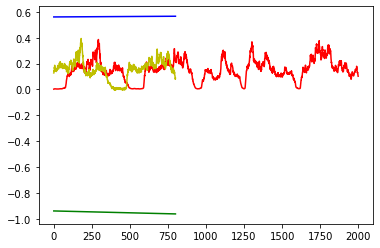

Iter: 720, running avg elbo: -144297243.3139


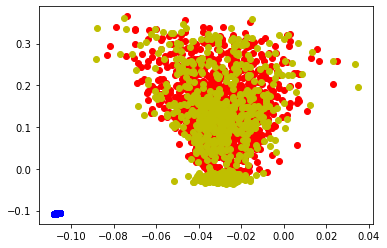

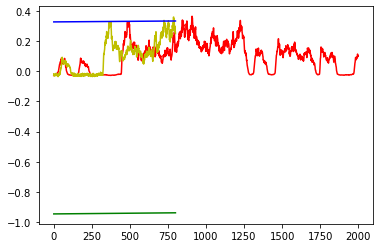

Iter: 730, running avg elbo: -144342567.3234


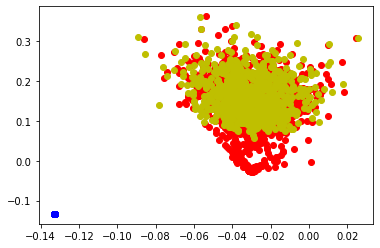

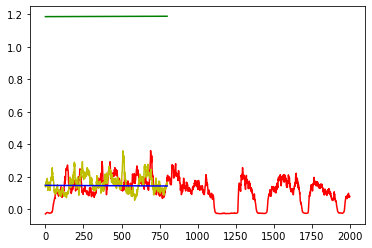

Iter: 740, running avg elbo: -144359308.8440


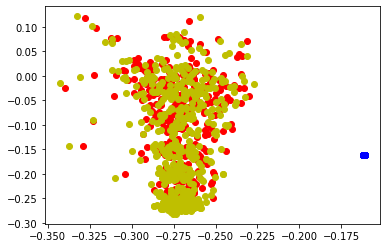

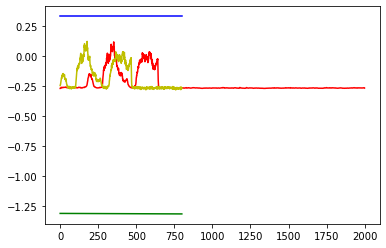

Iter: 750, running avg elbo: -144431030.2390


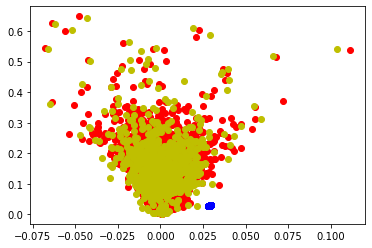

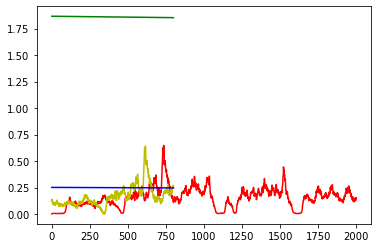

Iter: 760, running avg elbo: -144503071.9105


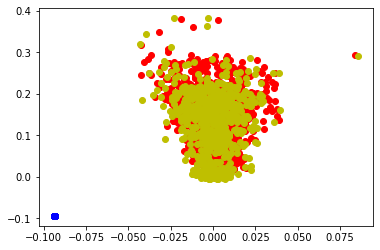

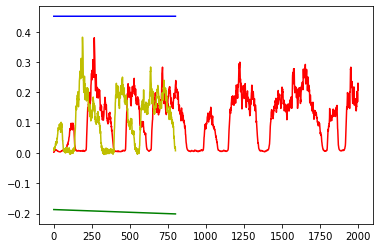

Iter: 770, running avg elbo: -144428633.1764


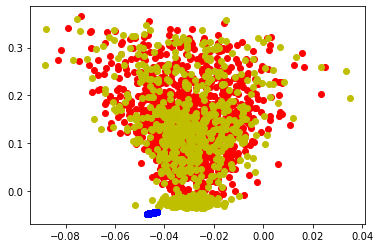

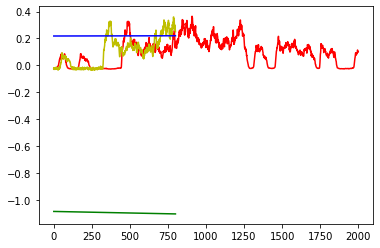

Iter: 780, running avg elbo: -144447900.8042


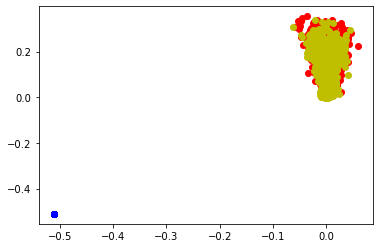

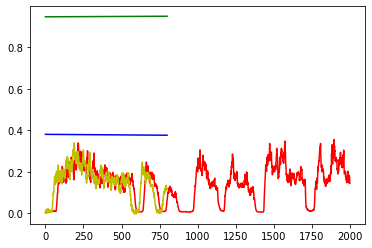

Iter: 790, running avg elbo: -144314185.9068


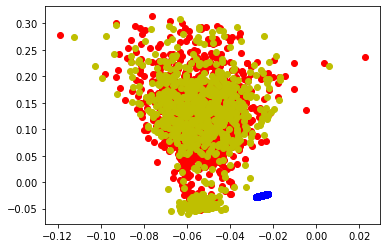

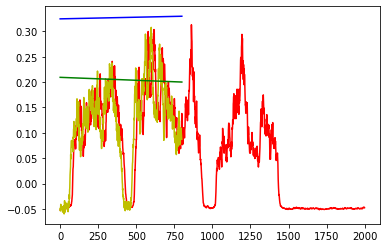

Iter: 800, running avg elbo: -144322106.5506


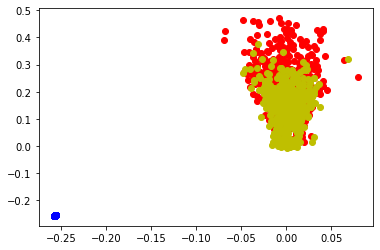

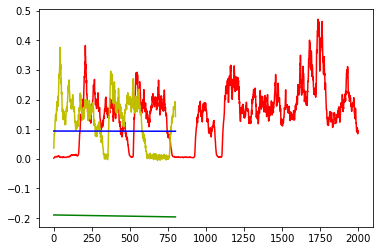

Iter: 810, running avg elbo: -144306716.4874


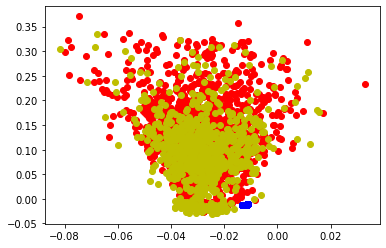

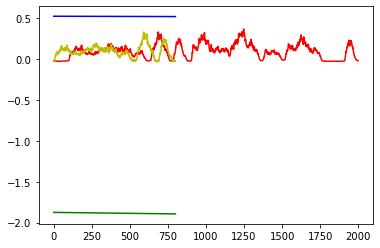

Iter: 820, running avg elbo: -144415937.3385


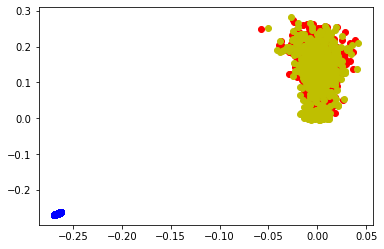

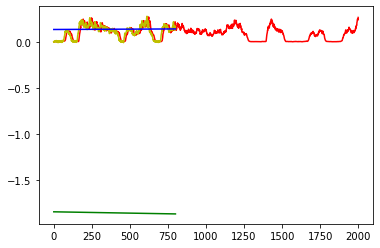

Iter: 830, running avg elbo: -144314573.9873


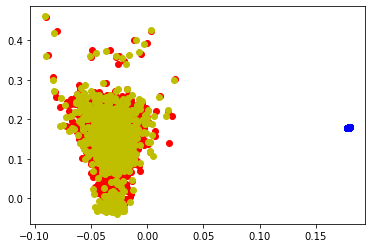

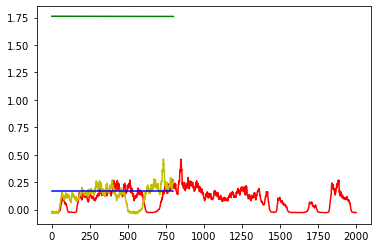

Iter: 840, running avg elbo: -144199037.3333


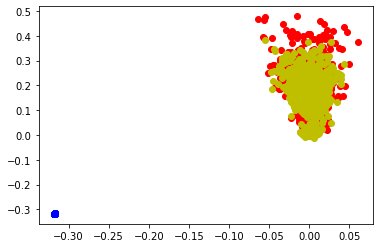

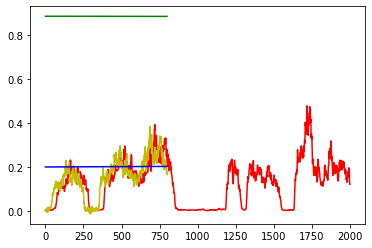

Iter: 850, running avg elbo: -144192805.2678


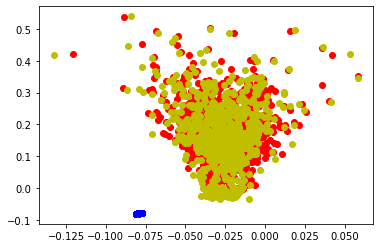

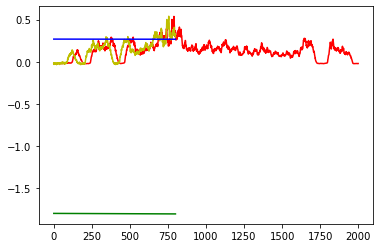

Iter: 860, running avg elbo: -144217876.6386


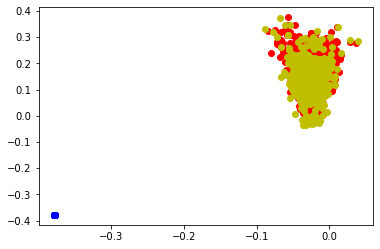

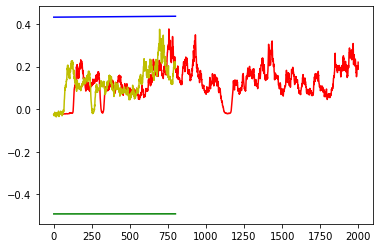

Iter: 870, running avg elbo: -144227878.0960


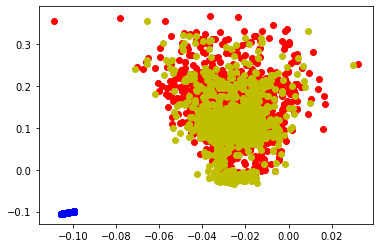

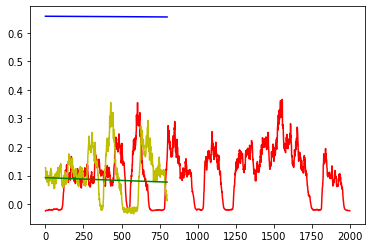

Iter: 880, running avg elbo: -144201850.9528


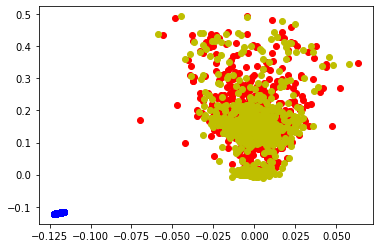

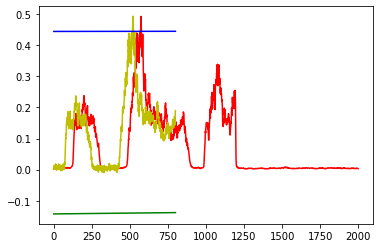

Iter: 890, running avg elbo: -144109375.4812


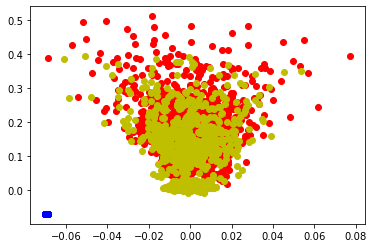

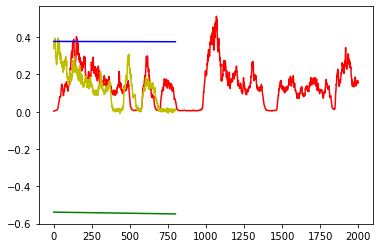

Iter: 900, running avg elbo: -144216885.1022


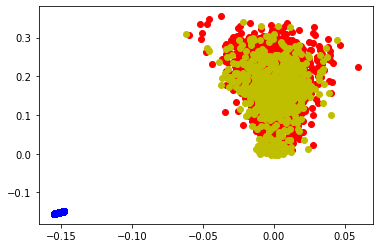

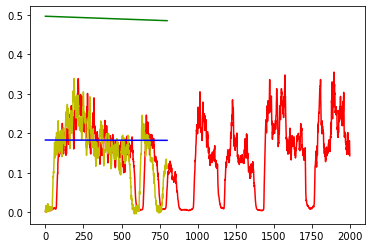

Iter: 910, running avg elbo: -144389559.6037


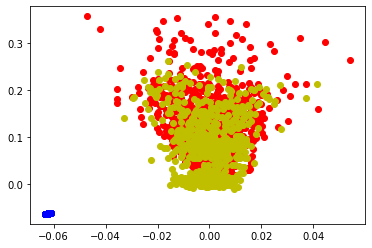

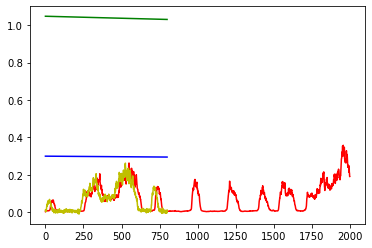

Iter: 920, running avg elbo: -144446901.5675


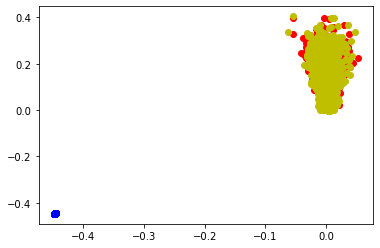

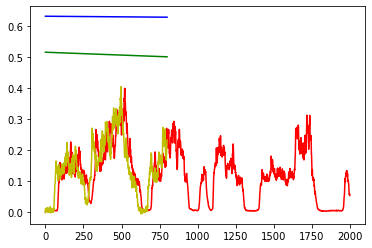

Iter: 930, running avg elbo: -144489430.5190


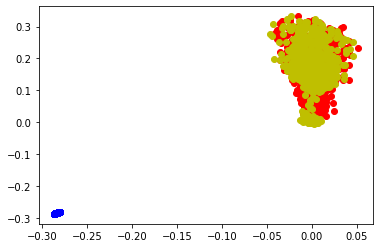

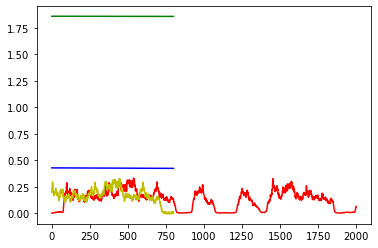

Iter: 940, running avg elbo: -144443851.6785


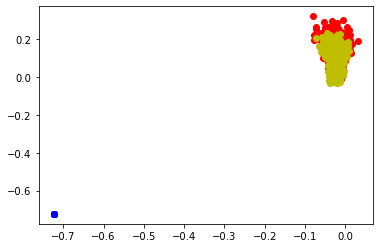

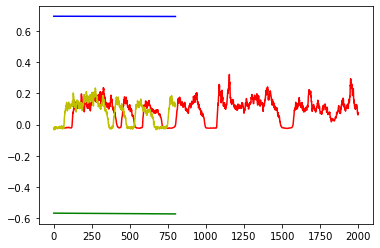

Iter: 950, running avg elbo: -144399487.8448


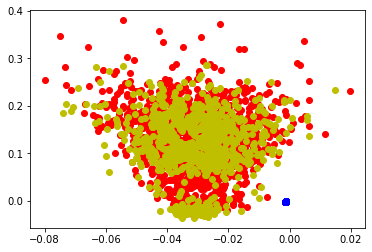

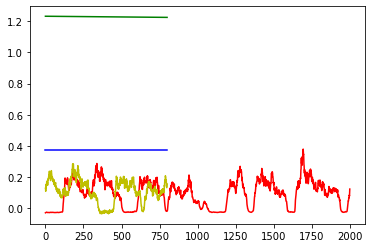

In [ ]:
train_dir='./'
niters = 10000
for itr in range(1, niters+1):
    optimizer.zero_grad()
    # backward in time to infer q(z_0)
    h = rec.initHidden().to(device) # for recurrent nn
    for t in reversed(range(samp_trajs.size(1))):
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs.view(140,-1), h) # init forward pass to create batch_y0 for training
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    #print('out is',out)
    epsilon = torch.randn(qz0_mean.size()).to(device)
    #print('epsilon is',epsilon)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
    # forward in time and solve ode for reconstructions
    #print('z0.shape is',z0.shape)
    #print('samp_ts.shape is',samp_ts.shape)
    #print(samp_ts)
    pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
    #print('pred_z.shape is',pred_z.shape)
    pred_x = dec(pred_z,280)  #decode
    # compute loss
    noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
    noise_logvar = 2. * torch.log(noise_std_).to(device)
#    print(samp_trajs.shape)
    #print(pred_x.shape)
    logpx = log_normal_pdf(samp_trajs.view(140,800,-1), pred_x, noise_logvar).sum(-1).sum(-1)
    pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
    analytic_kl = normal_kl(qz0_mean, qz0_logvar,pz0_mean, pz0_logvar).sum(-1)
    loss = torch.mean(-logpx + analytic_kl, dim=0)
    loss.backward(retain_graph=True)
    optimizer.step()
    loss_meter.update(loss.item())
    if itr % 10 == 0:
        print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -loss_meter.avg))
#       z0 = z0[index]
#       ts_pos = np.linspace(ntotal, ntotal+cutoff, num=cutoff)
#       ts_neg = np.linspace(-cutoff, 0., num=cutoff)[::-1].copy()
#       ts_pos = torch.from_numpy(ts_pos).float().to(device)
#       ts_neg = torch.from_numpy(ts_neg).float().to(device)
#       zs_pos = odeint(func, z0, ts_pos)
#       zs_neg = odeint(func, z0, ts_neg)
#       xs_pos = dec(zs_pos)
#       xs_neg = torch.flip(dec(zs_neg), dims=[0])
#       xs_pos = xs_pos.detach().cpu().numpy()
#       xs_neg = xs_neg.detach().cpu().numpy()
#       orig_traj = orig_trajs[0].detach().cpu().numpy()
#       samp_traj = samp_trajs[0].detach().cpu().numpy()
#       plt.figure()
#       plt.scatter(orig_traj[:, 0], orig_traj[:, 1], label='true trajectory')
#       plt.scatter(xs_pos[:, 0], xs_pos[:, 1], label='learned trajectory (t>0)')
#       plt.plot(xs_neg[:, 0], xs_neg[:, 1], label='learned trajectory (t<0)')
#       plt.legend()
#       plt.show()
#       plt.figure()
#       plt.plot(np.arange(cutoff, ntotal), samp_trajs[index,:, 1].detach().cpu().numpy())
#       plt.plot(np.arange(0, cutoff), np.clip(xs_pos[:, 1], -100, 100))
#       plt.plot(np.arange(ntotal, ntotal+cutoff), np.clip(xs_neg[:, 1], -100,  100))
#       plt.show()
        predx=pred_x.detach().cpu().numpy().reshape(140,800,2,44)
        predz=pred_z.detach().cpu().numpy().reshape(140,800,44)
        index = np.random.randint(samp_trajs.shape[0])
        plt.figure()
        plt.scatter(orig_trajs[index,:2000, 0,10].detach().cpu().numpy(), orig_trajs[index,:2000, 1,10].detach().cpu().numpy(), label='sampled',c='r') #1000
        plt.scatter(samp_trajs[index,:2000, 0,10].detach().cpu().numpy(), samp_trajs[index,:2000, 1,10].detach().cpu().numpy(), label='sampled',c='y') #1000
        plt.scatter(predx[index,:,0, 10], predx[index,:, 0,10], label='sampled',c='b') #1000
        plt.show()
        plt.figure()
        plt.plot(orig_trajs[index,:2000, 1,10].detach().cpu().numpy(),c='r')
        plt.plot(samp_trajs[index,:2000, 1,10].detach().cpu().numpy(),c='y')
        plt.plot(predx[index,:,1, 10],c='b')
        plt.plot(predz[index,:,10],c='g')
        plt.show()

In [381]:
def loss_backprop(generator, criterion, out, targets, normalize, bp=True):
    """
    Memory optmization. Compute each timestep separately and sum grads.
    """
    assert out.size(1) == targets.size(1)
    total = 0.0
    out_grad = []
    for i in range(out.size(1)):
        out_column = Variable(out[:, i].data, requires_grad=True)
        gen = generator(out_column)
        loss = criterion(gen, targets[:, i]) / normalize
        total += loss.data[0]
        loss.backward()
        out_grad.append(out_column.grad.data.clone())
    if bp:
        out_grad = torch.stack(out_grad, dim=1)
        out.backward(gradient=out_grad)

In [ ]:
#same func as in last colab, we'll use this in training to calculate and show loss
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()
    def reset(self):
        self.val = None
        self.avg = 0
    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [382]:
def make_std_mask(src, tgt, pad):
    "Create a mask to hide padding and future words."
    src_mask = (src != pad).unsqueeze(-2)
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(
        subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return src_mask, tgt_mask

class Batch:
    "Batch object."
    def __init__(self, src, trg, src_mask, trg_mask, ntokens):
        self.src = src
        self.trg = trg
        self.src_mask = src_mask
        self.trg_mask = trg_mask
        self.ntokens = ntokens

In [149]:
N = 140
latent_dim = 44
nhidden = 44
rnn_nhidden = 88
obs_dim = 88
nspiral = N #len(beats)
noise_std = 0.005
ntotal = 1000
cutoff = 200
nsample = ntotal - cutoff

In [383]:
def train_epoch(train_iter, model, criterion, opt):
    "Standard Training and Logging Function"
    model.train()
    for i, batch in enumerate(train_iter):
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, 
                             out, trg[:, 1:], batch.ntokens) 
                        
        model_opt.step()
        model_opt.optimizer.zero_grad()
        if i % 10 == 1:
            print(i, loss, model_opt._rate)

In [384]:
def valid_epoch(valid_iter, model, criterion):
    "Standard validation function"
    model.eval()
    total = 0
    total_tokens = 0
    for batch in valid_iter:
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], 
                            src_mask, trg_mask[:, :-1, :-1])
        total += loss_backprop(model.generator, criterion, out, trg[:, 1:], 
                             batch.ntokens, bp=False) * batch.ntokens
        total_tokens += batch.ntokens
    return total / total_tokens

In [164]:
class RecognitionRNN(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2) # Note that we are outputing twice the size of latent dim, this will go in as qz0_mean and qz0_logvar ... see training loop
    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h
    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)

In [165]:
beats = np.load('control_beats_6.npy')
beats2=DS.train_dl.reshape(140,10000,DS.dim)
print(DS.train_dl.shape)
print(beats.shape)
get_mes(beats2)

(1400000, 44)
(10411, 500)
输入的是一个 <class 'numpy.ndarray'>
数组长度 44 数组宽度 10000 数组高度 140
数组形状 (140, 10000, 44) 最大值 1.0000001 最小值 0.0


In [288]:
func = LcODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nspiral).to(device)

In [167]:
def generate_beats(beats_npy = beats, 
                   ntotal = len(beats[0]) - 1,
                   nsample = 200,
                   noise_std = 0.00,): 
    orig_ts = np.linspace(0, 1, num=len(beats_npy[0])-1)
    print(orig_ts.shape)
    samp_ts = orig_ts[:nsample]
    print(samp_ts.shape)
    xs = np.array([np.diff(single_beat,axis=0) for single_beat in beats_npy])
    #for single_beat in beats_npy:
    #    print(single_beat.shape)
    print(xs.shape)
    ys = np.array([single_beat[:-1] for single_beat in beats_npy])
    print(ys.shape)
    orig_trajs = np.stack((xs, ys), axis=2)#[:1000]
    samp_trajs = []
    for i in range(len(orig_trajs)):
        orig_traj = orig_trajs[i]
        orig_traj = remap(orig_traj, -1, 1)
        orig_trajs[i] = orig_traj
        samp_traj = orig_traj.copy()
        idx0 = np.random.randint(ntotal - nsample)
        samp_traj = samp_traj[idx0:idx0+nsample,:,:]
        samp_traj += npr.randn(*samp_traj.shape) * noise_std
        samp_trajs.append(samp_traj)
    # batching for sample trajectories is good for RNN; batching for original
    # trajectories only for ease of indexing
    orig_trajs = np.stack(orig_trajs, axis=0)
    print(orig_trajs.shape)
    samp_trajs = np.stack(samp_trajs, axis=0)
    print(samp_trajs.shape)
    return orig_trajs, samp_trajs, orig_ts, samp_ts
  

In [168]:
# generate toy spiral data like before
orig_trajs, samp_trajs, orig_ts, samp_ts = generate_beats(beats2[:N], ntotal, nsample, noise_std)
orig_trajs.shape, samp_trajs.shape, orig_ts.shape, samp_ts.shape

(9999,)
(800,)
(140, 9999, 44)
(140, 9999, 44)
(140, 9999, 2, 44)
(140, 800, 2, 44)


((140, 9999, 2, 44), (140, 800, 2, 44), (9999,), (800,))

(9999,)
(800,)


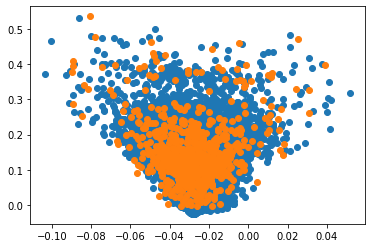

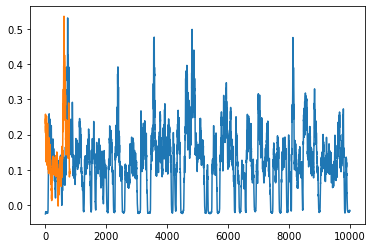

In [169]:
index = 0
print(orig_trajs[index, :, 0,10].shape)
print(samp_trajs[index, :, 0,10].shape)
plt.figure()
plt.scatter(orig_trajs[index, :, 0,10], orig_trajs[index, :, 1,10])
plt.scatter(samp_trajs[index, :, 0,10], samp_trajs[index, :, 1,10])
plt.show()
plt.figure()
plt.plot(orig_trajs[index, :, 1,10])
plt.plot(samp_trajs[index, :, 1,10])
plt.show()

In [170]:
orig_trajs = torch.from_numpy(orig_trajs).float().to(device)
samp_trajs = torch.from_numpy(samp_trajs).float().to(device)
samp_ts = torch.from_numpy(samp_ts).float().to(device)

In [171]:
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
#params

In [354]:
optimizer = optim.Adam(params, lr=0.1)
loss_meter = RunningAverageMeter()

In [173]:
samp_trajs.shape, orig_trajs.shape

(torch.Size([140, 800, 2, 44]), torch.Size([140, 9999, 2, 44]))

In [174]:
#playing with functions in training loop
print(samp_trajs.size())
print(samp_trajs.size(1)) # total dataset size of spirals is 1000 spirals but each sampled spiral has 100 datapoints

h = rec.initHidden().to(device) # for recurrent nn
for t in reversed(range(samp_trajs.size(1))):
    obs = samp_trajs[:, t, :,:]
#         print(obs.shape)
    print(h.shape)
    print(obs.shape)
    out, h = rec.forward(obs.view(140,-1), h) # init forward pass to start rnn

print(out.size(), h.size()) #weights

qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
epsilon = torch.randn(qz0_mean.size()).to(device)
z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

print('z0 size = ', z0.size())
pred_z = odeint(func, z0, samp_ts)
print('pred_z size = ', pred_z.size())
pred_z = pred_z.permute(1, 0, 2)
print('pred_z size after changing axes = ',pred_z.size())
pred_x = dec(pred_z)
print('pred_x size = ',pred_x.size())

torch.Size([140, 800, 2, 44])
800
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torc

torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([1

torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([1

torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([140, 88])
torch.Size([140, 2, 44])
torch.Size([1

In [175]:
def log_normal_pdf(x, mean, logvar):
#     const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
#     const = torch.log(const)
#     return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))
    return -.5 * (logvar + (x - mean) ** 2. / torch.exp(logvar))
def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.
    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

In [44]:
optimizer.zero_grad()
# backward in time to infer q(z_0)
h = rec.initHidden().to(device) # for recurrent nn
for t in reversed(range(samp_trajs.size(1))):
    obs = samp_trajs[:, t, :]
    out, h = rec.forward(obs, h)
qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
epsilon = torch.randn(qz0_mean.size()).to(device)
z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

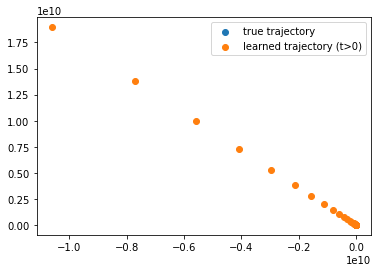

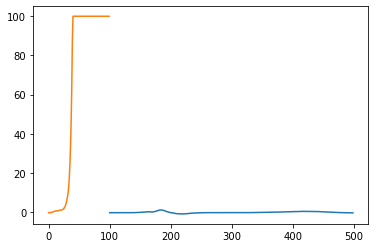

In [45]:
# take first trajectory for visualization
index = np.random.randint(samp_trajs.shape[0])
z0 = z0[index]
ts_pos = np.linspace(ntotal, ntotal+cutoff, num=cutoff)
# ts_neg = np.linspace(-cutoff, 0., num=cutoff)[::-1].copy()
ts_pos = torch.from_numpy(ts_pos).float().to(device)
# ts_neg = torch.from_numpy(ts_neg).float().to(device)
zs_pos = odeint(func, z0, ts_pos)
# zs_neg = odeint(func, z0, ts_neg)
xs_pos = dec(zs_pos)
# xs_neg = torch.flip(dec(zs_neg), dims=[0])
xs_pos = xs_pos.detach().cpu().numpy()
# xs_neg = xs_neg.detach().cpu().numpy()
orig_traj = orig_trajs[0].detach().cpu().numpy()
samp_traj = samp_trajs[0].detach().cpu().numpy()
plt.figure()
plt.scatter(orig_traj[:, 0], orig_traj[:, 1], label='true trajectory')
plt.scatter(xs_pos[:, 0], xs_pos[:, 1], label='learned trajectory (t>0)')
# plt.plot(xs_neg[:, 0], xs_neg[:, 1], label='learned trajectory (t<0)')
plt.legend()
plt.show()
plt.figure()
plt.plot(np.arange(cutoff, ntotal), samp_trajs[index,:, 1].detach().cpu().numpy())
plt.plot(np.arange(0, cutoff), np.clip(xs_pos[:, 1], -100, 100))
# plt.plot(np.arange(ntotal, ntotal+cutoff), np.clip(xs_neg[:, 1], -100,  100))
plt.show()